In [36]:
import torch

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from numba import jit
from numpy import zeros, arange, uint8, int32, float32, sqrt, uint32, ones, vstack, concatenate
from numpy import int64, mean, ceil, where, log2, max, min, median, var, log, array, sum
from numpy.random import randn, uniform
from numpy.fft import fft, ifft, fftfreq
from sbi import utils as utils
from scipy.integrate import cumulative_trapezoid
from scipy.signal import welch
import numpy as np
import torch
import os
import _pickle as pickle
from scipy.optimize import curve_fit
from scipy.stats import zscore

In [75]:
def corr(x,y,nmax,dt=False):
    '''
    Performs the cross correlation between two single-input signals x and y.

    INPUT
    x: input signal 1
    y: input signal 2
    nmax: maximum number of lags
    dt: time step (default=False)

    OUTPUT
    corr: cross-correlation between x and y
    '''

    assert len(x)==len(y), 'x and y must have the same length'

    n=len(x)
    # pad 0s to 2n-1
    ext_size=2*n-1
    # nearest power of 2
    fsize=2**ceil(log2(ext_size)).astype('int')

    xp=x-mean(x)
    yp=y-mean(y)

    # do fft and ifft
    cfx=fft(xp,fsize)
    cfy=fft(yp,fsize)
    if dt != False:
        freq = fftfreq(n, d=dt)
        idx = where((freq<-1/(2*dt))+(freq>1/(2*dt)))[0]
        
        cfx[idx]=0
        cfy[idx]=0
        
    sf=cfx.conjugate()*cfy
    corr=ifft(sf).real
    corr=corr/n

    return corr[:nmax]

def stat_corr_single(single_x_trace, DeltaT, t, t_corr):
    '''
    Computes the autocorrelation for a single x trace signal.

    INPUT
    singles_x_trace: single x trace signal
    DeltaT: sampling time
    t: time array
    t_corr: maximum time for the correlation

    OUTPUT
    Cxx: autocorrelation x signal
    '''

    sampled_point_amount = single_x_trace.shape[0]
    idx_corr = np.where((t>0)*(t<t_corr))[0]
    Cxx= corr(single_x_trace, single_x_trace, sampled_point_amount, dt=DeltaT) # compute the autocorrellation for each x trace

    return Cxx

def stat_s_redx(Cxx, t_corr, t, mu_x=1, k_x=1, kbT=1):
    '''
    Computes the reduced energy production for a single x trace signal.

    INPUT
    Cxx: autocorrelation signal
    t_corr: maximum time for the correlation
    t: time array
    theta_i: parameters

    OUTPUT
    S_red: reduced x energy production
    '''
    D_x = kbT * mu_x
    
    S1 = cumulative_trapezoid(Cxx, x=t, axis=-1, initial=0)
    S1 = cumulative_trapezoid(S1, x=t, axis=-1, initial=0)
    #idx_corr = where((t>0)*(t<t_corr))[0]
    S_red1 = (Cxx[0]-Cxx)/(D_x*t) # First term in S_red
    S_red2 = ((mu_x*k_x)**2)*S1/(D_x*t) # Second term in S_red
    S_red = S_red1 + S_red2 # Compute S_red

    return S_red1, S_red2, S_red

In [88]:
# Define the simulator. This is one of the TWO bottlenecks of the pipeline
def Simulator(theta):
    A, omega = theta
    trace = np.zeros((1,100))
    for t in np.arange(0, 10, 0.1):
        trace[0,int(t*10)] = A*np.sin(omega * t) + np.random.randn()*0.1
    
    cxx = stat_corr_single(trace[0],0.1,np.arange(0,10,0.1),1)
    trace = stat_s_redx(cxx, 1, np.arange(0,10,0.1))[2]
    
    tra = torch.from_numpy(trace[1:])
    return tra.reshape_as(torch.zeros((99)))

true_theta = torch.tensor([1, 1])

/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_83159/2453967803.py:80: RuntimeWarning: invalid value encountered in divide
  S_red1 = (Cxx[0]-Cxx)/(D_x*t) # First term in S_red
/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_83159/2453967803.py:81: RuntimeWarning: invalid value encountered in divide
  S_red2 = ((mu_x*k_x)**2)*S1/(D_x*t) # Second term in S_red


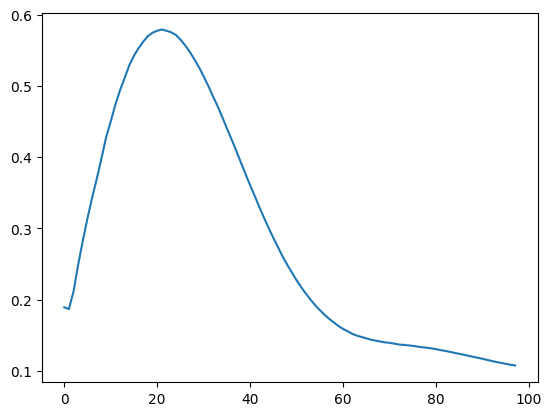

In [90]:
trace = Simulator(true_theta)
plt.plot(trace[1:])

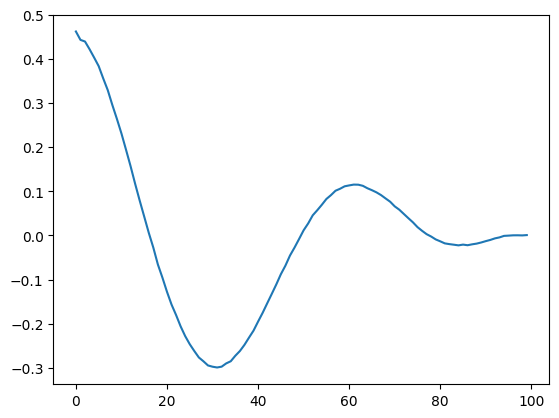

In [56]:
plt.plot(trace)

$$
x(t) = Ae^{-\frac{bt}{2m}} \cos{(\omega_{damp}t + \phi)}
$$

$$
\omega_{damp} = \frac{k}{m} - \frac{b^2}{4m^2}
$$

In [91]:
# Define the prior. PRIOR is used to sample (and only for that)
Prior = utils.BoxUniform(low=torch.tensor([0.0, 0.0]), high=torch.tensor([5.0, 5.0]))

In [92]:
# This cell is a safety check to ensure everything returns the right type of object. These function effectvley create
# new functions that adhere to the sbi API. They are not necessary to understand, but they are necessary to run the code.

# Check prior, return PyTorch prior.
Prior, num_parameters, prior_returns_numpy = process_prior(Prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
Simulator = process_simulator(Simulator, Prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(Simulator, Prior)

/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_83159/2453967803.py:80: RuntimeWarning: invalid value encountered in divide
  S_red1 = (Cxx[0]-Cxx)/(D_x*t) # First term in S_red
/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_83159/2453967803.py:81: RuntimeWarning: invalid value encountered in divide
  S_red2 = ((mu_x*k_x)**2)*S1/(D_x*t) # Second term in S_red


In [93]:
# This is the meat of the method. TODO: Understand this better!!
inference = SNPE(prior=Prior)

In [94]:
# THE SIMULATION CAN BE DONE ELSEWHERE!!! With this function it seems that the prior is sampled randomly.
# This bitch don't parallelize, its a lie!!
theta, x = simulate_for_sbi(Simulator, proposal=Prior, num_simulations=10000, num_workers=-1)
theta

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_83159/2453967803.py:80: RuntimeWarning: invalid value encountered in divide
/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_83159/2453967803.py:80: RuntimeWarning: invalid value encountered in divide
/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_83159/2453967803.py:81: RuntimeWarning: invalid value encountered in divide
/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_83159/2453967803.py:81: RuntimeWarning: invalid value encountered in divide
/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_83159/2453967803.py:80: RuntimeWarning: invalid value encountered in divide
/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_83159/2453967803.py:81: RuntimeWarning: invalid value encountered in divide
/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_83159/2453967803.py:80: RuntimeWarning: invalid value encountered in divide
/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipyker

tensor([[2.4253, 1.4333],
        [4.2305, 2.5773],
        [3.4676, 2.6567],
        ...,
        [0.5409, 3.0502],
        [2.4144, 0.4593],
        [1.9858, 0.8979]])

In [95]:
print("Shape theta", theta.shape)
print("Shape x: ", x.shape)

Shape theta torch.Size([10000, 2])
Shape x:  torch.Size([10000, 99])


In [96]:
inference = inference.append_simulations(theta, x) # Give the simulations to the inference objects! This is where we would use our simulation

In [97]:
# Seems like smaller batch sizes are better for training. See: https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu

# Idea: use multi-round inference to get better results. See: https://sbi-dev.github.io/sbi/tutorial/03_multiround_inference/

density_estimator = inference.train() # This is almost a neural network object (there are more things inside, to be understoo better)

 Neural network successfully converged after 108 epochs.

In [98]:
posterior = inference.build_posterior(density_estimator)

print(posterior) # prints how the posterior was trained

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [99]:
theta_true = torch.tensor([[1.0, 1.0]])
# generate our observation
x_obs = Simulator(theta_true)
x_obs.shape

/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_83159/2453967803.py:80: RuntimeWarning: invalid value encountered in divide
  S_red1 = (Cxx[0]-Cxx)/(D_x*t) # First term in S_red
/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_83159/2453967803.py:81: RuntimeWarning: invalid value encountered in divide
  S_red2 = ((mu_x*k_x)**2)*S1/(D_x*t) # Second term in S_red


torch.Size([1, 99])

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

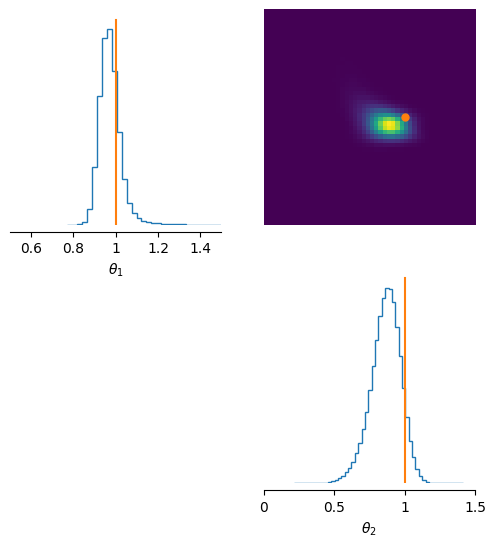

In [100]:
samples = posterior.sample((1000000,), x=x_obs)
_ = analysis.pairplot(samples, points=theta_true, limits=[[0.5, 1.5], [0, 1.5]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$"])

# I really don't like this error! More samples don't seem to help. The distribution is the same anyway... Look at the multi-round inference
# More simulation to train the neural network in this case worsened the results...
# See plot in the end of the notebook for visual error

In [32]:
# first sample an alternative parameter set from the prior
theta_diff = Prior.sample((1,))

In [33]:
log_probability_true_theta = posterior.log_prob(theta_true, x=x_obs)
log_probability_diff_theta = posterior.log_prob(theta_diff, x=x_obs)
log_probability_samples = posterior.log_prob(samples, x=x_obs)

print( r'high for true theta :', log_probability_true_theta)
print( r'low for different theta :', log_probability_diff_theta)
print( r'range of posterior samples: min:', torch.min(log_probability_samples),' max :', torch.max(log_probability_samples))

high for true theta : tensor([6.3318])
low for different theta : tensor([-46738.6680])
range of posterior samples: min: tensor(-7.3864)  max : tensor(6.4948)


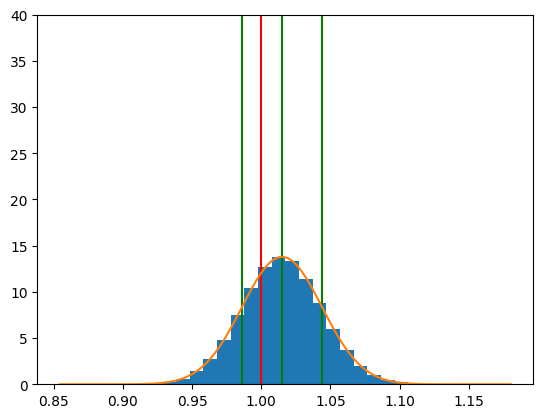

In [34]:
# This is really bad! The true value is outside one sigma!!

data = samples[:,0]
mean,std=norm.fit(data)
plt.hist(data, bins=30, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.vlines(x=mean, ymin=0, ymax=40, color='g')
plt.ylim(0, 40)
plt.vlines(x=mean-std, ymin=0, ymax=40, color='g')
plt.vlines(x=mean+std, ymin=0, ymax=40, color='g')
plt.vlines(x=theta_true[0,0], ymin=0, ymax=40, color='r')
plt.plot(x, y)
plt.show()